Code to predict type of pmeumonia from exray of chest of patient.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from os import listdir
from os.path import isfile, join
import numpy as np
import tensorflow as tf
from PIL import Image as img
from tensorflow.python import keras
from keras import Sequential, datasets, layers, models
import pickle as pk

Various imports needed.

In [2]:
pixels = 150
dimensions = (pixels, pixels)
bins = 2
mid_layer = 750
training_iters = 10
learning_rate = 2e-3
num_epochs = 3
reduction_factor = 0.9

Variables defined

In [3]:
class LearningRateReducerCb(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        old_lr = self.model.optimizer.lr.read_value()
        new_lr = old_lr * reduction_factor
        print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
        self.model.optimizer.lr.assign(new_lr)

Reduces learning rate by epochs.

In [4]:
train_images = []
train_labels = np.array([])
folder_path = "/mnt/c/NN/Pneumonia/chest_xray/train/"

for f in listdir(folder_path + "NORMAL"):
    im = img.open(folder_path + "NORMAL/" + f)
    im = im.resize(dimensions)
    im = im.convert('L')
    im_array = np.asarray(im)
    train_images.append(im_array)
    im.close()
    train_labels = np.append(train_labels, 0)

num_normal = np.size(train_labels)

for f in listdir(folder_path + "PNEUMONIA"):
    im = img.open(folder_path + "PNEUMONIA/" + f)
    im = im.resize(dimensions)
    im = im.convert('L')
    im_array = np.asarray(im)
    train_images.append(im_array)
    im.close()

    train_labels = np.append(train_labels, 1)    
    
    if np.size(train_labels) >= 2 * num_normal:
        break
    
train_images = np.array(train_images)
train_images = train_images / 255.0

# test_images = []
# test_labels = np.array([])
# folder_path = "/mnt/c/NN/Pneumonia/chest_xray/test/"

# for f in listdir(folder_path + "NORMAL"):
#     im = img.open(folder_path + "NORMAL/" + f)
#     im = im.resize(dimensions)
#     im = im.convert('L')
#     im_array = np.asarray(im)
#     test_images.append(im_array)
#     im.close()    
#     test_labels = np.append(test_labels, 0)

# for f in listdir(folder_path + "PNEUMONIA"):
#     im = img.open(folder_path + "PNEUMONIA/" + f)
#     im = im.resize(dimensions)
#     im = im.convert('L')
#     im_array = np.asarray(im)
#     test_images.append(im_array)
#     im.close()

#     test_labels = np.append(test_labels, 1)    

# test_images = np.array(test_images)

# test_images = test_images / 255.0

In [5]:
print(np.shape(train_images))
print(np.shape(train_labels))

(2682, 150, 150)
(2682,)


In [6]:
np.size(train_labels, 0)

2682

In [7]:
randomize = np.arange(np.size(train_labels, 0))
np.random.shuffle(randomize)
train_images = train_images[randomize]
train_labels = train_labels[randomize]

test_images = train_images[int(0.8 * np.size(train_labels)):, :, :]
test_labels = train_labels[int(0.8 * np.size(train_labels)):]

train_images = train_images[:int(0.8 * np.size(train_labels)), :, :]
train_labels = train_labels[:int(0.8 * np.size(train_labels))]

train_images = np.squeeze(train_images)
test_images = np.squeeze(test_images)
train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

In [8]:
print(np.shape(train_images))
print(np.shape(train_labels))

(2145, 150, 150)
(2145,)


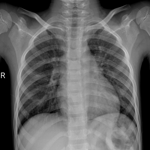

0.0


In [21]:
(img.fromarray(255 * train_images[5])).show()
print(train_labels[6])

In [9]:
unique, counts = np.unique(train_labels, return_counts=True)
print(dict(zip(unique, counts)))

{0.0: 1067, 1.0: 1078}


Images Imported
Average time taken = 150 seconds.

In [22]:
model = models.Sequential()
model.add(layers.Conv2D(pixels, (3, 3), activation='relu', input_shape=(pixels, pixels, 1)))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(2 * pixels, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(2 * pixels, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(pixels, activation='relu'))
model.add(layers.Dense(bins))

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Creates CNN model

In [23]:
history = model.fit(train_images, train_labels, callbacks=[LearningRateReducerCb()], epochs=num_epochs,
                    validation_data=(test_images, test_labels))

Epoch 1/3
68/68 [==============================] - ETA: 0s - loss: 1.4884 - accuracy: 0.7911
Epoch: 0. Reducing Learning Rate from 0.0020000000949949026 to 0.0018000000854954123
68/68 [==============================] - 251s 4s/step - loss: 1.4884 - accuracy: 0.7911 - val_loss: 0.2928 - val_accuracy: 0.8816
Epoch 2/3
68/68 [==============================] - ETA: 0s - loss: 0.1432 - accuracy: 0.9455
Epoch: 1. Reducing Learning Rate from 0.0018000000854954123 to 0.0016199999954551458
68/68 [==============================] - 276s 4s/step - loss: 0.1432 - accuracy: 0.9455 - val_loss: 0.1307 - val_accuracy: 0.9492
Epoch 3/3
68/68 [==============================] - ETA: 0s - loss: 0.0966 - accuracy: 0.9627
Epoch: 2. Reducing Learning Rate from 0.0016199999954551458 to 0.0014579999260604382
68/68 [==============================] - 250s 4s/step - loss: 0.0966 - accuracy: 0.9627 - val_loss: 0.0975 - val_accuracy: 0.9627


Trains the model.
Number of epochs = 3
Training time = 33:27

In [24]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print("Accuracy = " + str(np.round(test_acc * 100, 3)) + " %")

68/68 - 47s - loss: 0.0975 - accuracy: 0.9627 - 47s/epoch - 698ms/step
Accuracy = 96.272 %


Prints accuracy for the model.
Validation Accuracy reached = 65

In [28]:
filename = 'model_bins_2.bin'
pk.dump(model, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://16e9e855-aace-42f0-8562-9c47a7c07bac/assets


In [ ]:
image = img.open("/mnt/c/NN/Pneumonia/chest_xray/train/NORMAL/IM-0115-0001.jpeg")
image = image.resize(dimensions)
image = image.convert('L')
image_array = np.asarray(image)
image_array = np.reshape(image_array, (pixels, pixels, 1))
image_array = np.expand_dims(image_array, 0)
image_array = image_array / 255.0

print(download_model.predict(image_array))